### EDA - Geophysical Tutorial Machine Learning Contest 2016 

In [14]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

Esses dados são do reservatório de gás de Council Grove, no sudoeste do Kansas. O Panoma Council Grove Field é predominantemente um reservatório de gás carbonato que abrange 2.700 milhas quadradas no sudoeste do Kansas. Este conjunto de dados é de nove poços (com 4149 amostras), consistindo em um conjunto de sete variáveis preditoras e uma fácies de rocha (classe) para cada vetor de exemplo e dados de validação (teste) (830 exemplos de dois poços) com as mesmas sete variáveis preditoras no vetor de recursos. As fácies são baseadas no exame de núcleos de nove poços tomados verticalmente em intervalos de meio pé. As variáveis preditoras incluem cinco de medições de perfil de cabo de aço e duas variáveis de restrição geológica que são derivadas do conhecimento geológico. Essas são essencialmente variáveis contínuas amostradas a uma taxa de amostragem de meio pé.

As sete variáveis preditoras são:

- Cinco curvas de log de cabo de aço incluem raios gama (GR), registro de resistividade (ILD_log10), efeito fotoelétrico (PE), diferença de porosidade de densidade de nêutrons e porosidade média de densidade de nêutrons (DeltaPHI e PHIND). Observe que alguns poços não possuem PE.

- Duas variáveis de restrição geológica: indicador marinho-não marinho (NM_M) e posição relativa (RELPOS)

As nove fácies discretas (classes de rochas) são:

arenito não marinho
Siltito grosso não marinho
Siltito fino não marinho
Siltito marinho e folhelho
Mudstone (calcário)
Wackestone (calcário)
Dolomite
Packstone-grainstone (calcário)
Bafflestone de algas filoides (calcário)

Essas fácies não são discretas e gradualmente se misturam umas às outras. Alguns têm fácies vizinhas bastante próximas. Pode-se esperar a ocorrência de rotulagem incorreta dentro dessas fácies vizinhas. A tabela a seguir lista as fácies, seus rótulos abreviados e seus vizinhos aproximados.

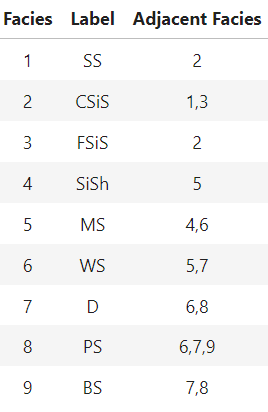

### 1 - Carregar banco de dados

O conjunto de dados é composto por 4149 amostras de 11 recursos, sendo 5 medições de perfilagem (GR, ILD_log10, DeltaPHI, PHIND, PE), duas variáveis indicadoras (NM_M e RELPOS) e um rótulo fácies (Facies) em intervalos de profundidade. (MELHORAR)

In [2]:
df = pd.read_csv('../Data/facies_vectors.csv')
print(df.shape)
df.head()

(4149, 11)


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Facies     4149 non-null   int64  
 1   Formation  4149 non-null   object 
 2   Well Name  4149 non-null   object 
 3   Depth      4149 non-null   float64
 4   GR         4149 non-null   float64
 5   ILD_log10  4149 non-null   float64
 6   DeltaPHI   4149 non-null   float64
 7   PHIND      4149 non-null   float64
 8   PE         3232 non-null   float64
 9   NM_M       4149 non-null   int64  
 10  RELPOS     4149 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 356.7+ KB


In [4]:
100*df.isnull().sum()/df.shape[0]

Facies        0.000000
Formation     0.000000
Well Name     0.000000
Depth         0.000000
GR            0.000000
ILD_log10     0.000000
DeltaPHI      0.000000
PHIND         0.000000
PE           22.101711
NM_M          0.000000
RELPOS        0.000000
dtype: float64

In [5]:
df[df['PE'].isnull()]['Well Name'].unique().tolist()

['ALEXANDER D', 'KIMZEY A', 'Recruit F9']

In [6]:
df['Well Name'].unique().tolist()

['SHRIMPLIN',
 'ALEXANDER D',
 'SHANKLE',
 'LUKE G U',
 'KIMZEY A',
 'CROSS H CATTLE',
 'NOLAN',
 'Recruit F9',
 'NEWBY',
 'CHURCHMAN BIBLE']

Let's clean up this dataset. The 'Well Name' and 'Formation' columns can be turned into a categorical data type.



In [8]:
df['Well Name'] = df['Well Name'].astype('category')
df['Formation'] = df['Formation'].astype('category')
df['Well Name'].unique()

['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (10, object): ['ALEXANDER D', 'CHURCHMAN BIBLE', 'CROSS H CATTLE', 'KIMZEY A', ..., 'NOLAN', 'Recruit F9', 'SHANKLE', 'SHRIMPLIN']

Estes são os nomes dos 10 poços de treinamento no reservatório de Council Grove. Os dados foram recrutados para o pseudo-poço 'Recruit F9' para melhor representar a fácies 9, o defletor de algas filoides.

Antes de plotarmos os dados do poço, vamos definir um mapa de cores para que as fácies sejam representadas por cores consistentes em todas as plotagens deste tutorial. Também criamos os rótulos de fácies abreviados e os adicionamos ao dataframe facies_vectors.

In [9]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
df.loc[:,'FaciesLabels'] = df.apply(lambda row: label_facies(row, facies_labels), axis=1)
df.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


Esta é uma visão rápida da distribuição estatística das variáveis de entrada. Observando os valores de contagem, a maioria dos valores tem 4149 valores válidos, exceto PE, que tem 3232. Neste tutorial, descartaremos os vetores de recursos que não possuem uma entrada de PE válida.

In [10]:
PE_mask = df['PE'].notnull().values
df = df[PE_mask]

Vamos dar uma olhada nos dados de poços individuais em uma forma de log plot mais familiar. Criaremos gráficos para as cinco variáveis de log de poço, bem como um log para rótulos de fácies. As tramas são baseadas nas descritas no excelente tutorial de Alessandro Amato del Monte.

In [11]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

We then show log plots for wells SHRIMPLIN and SHANKLE.

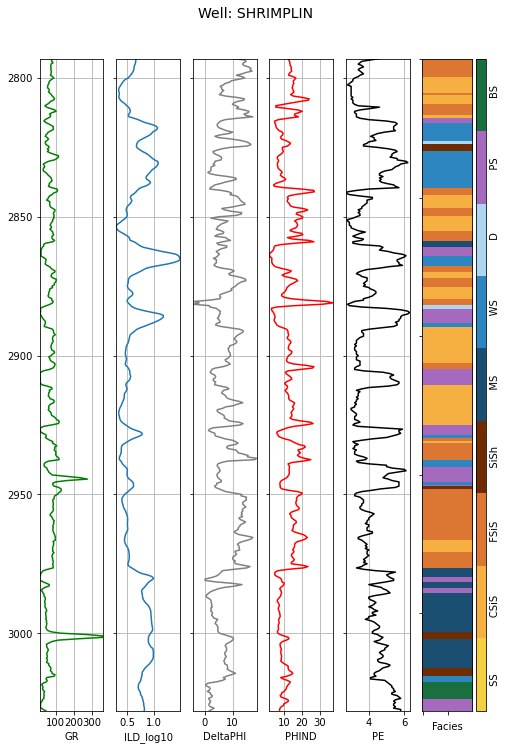

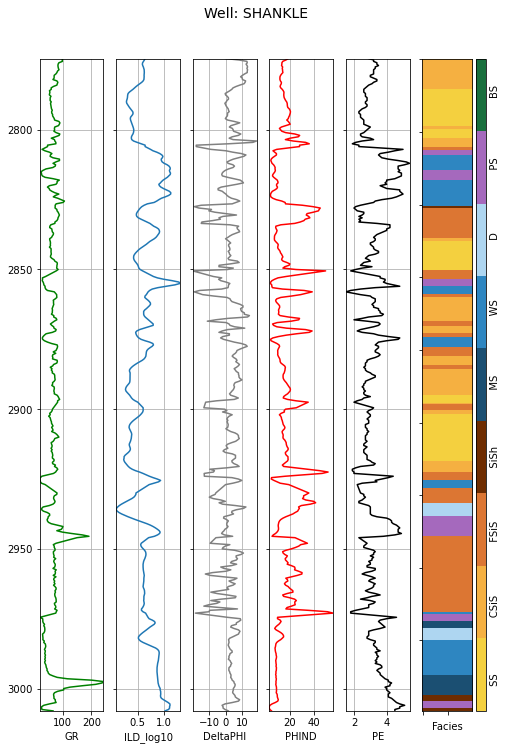

In [15]:
make_facies_log_plot(
    df[df['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

make_facies_log_plot(
    df[df['Well Name'] == 'SHANKLE'],
    facies_colors)

Além dos poços individuais, podemos observar como as várias fácies são representadas por todo o conjunto de treinamento. Vamos traçar um histgrama do número de exemplos de treinamento para cada classe de fácies.

SS      259
CSiS    738
FSiS    615
SiSh    184
MS      217
WS      462
D        98
PS      498
BS      161
Name: Facies, dtype: int64

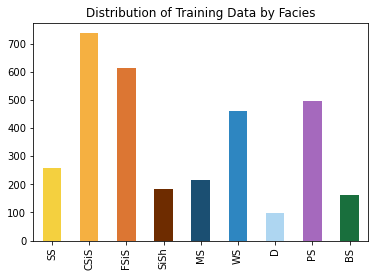

In [17]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = df['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

Isso mostra a distribuição de exemplos por fácies para os 3232 exemplos de treinamento no conjunto de treinamento. Dolomita (fácies 7) tem o menor número com 141 exemplares. Existem também apenas 185 exemplos de bafflestone. Dependendo do desempenho do classificador que vamos treinar, podemos considerar obter mais exemplos dessas fácies.

Crossplots são uma ferramenta familiar nas geociências para visualizar como duas propriedades variam com o tipo de rocha. Este conjunto de dados contém 5 variáveis de log e a matriz de dispersão pode ajudar a visualizar rapidamente a variação entre todas as variáveis no conjunto de dados. Podemos empregar a muito útil biblioteca Seaborn para criar rapidamente uma bela matriz de dispersão. Cada painel no gráfico mostra a relação entre duas das variáveis nos eixos x e y, com cada ponto colorido de acordo com suas fácies. O mesmo mapa de cores é usado para representar as 9 fácies.

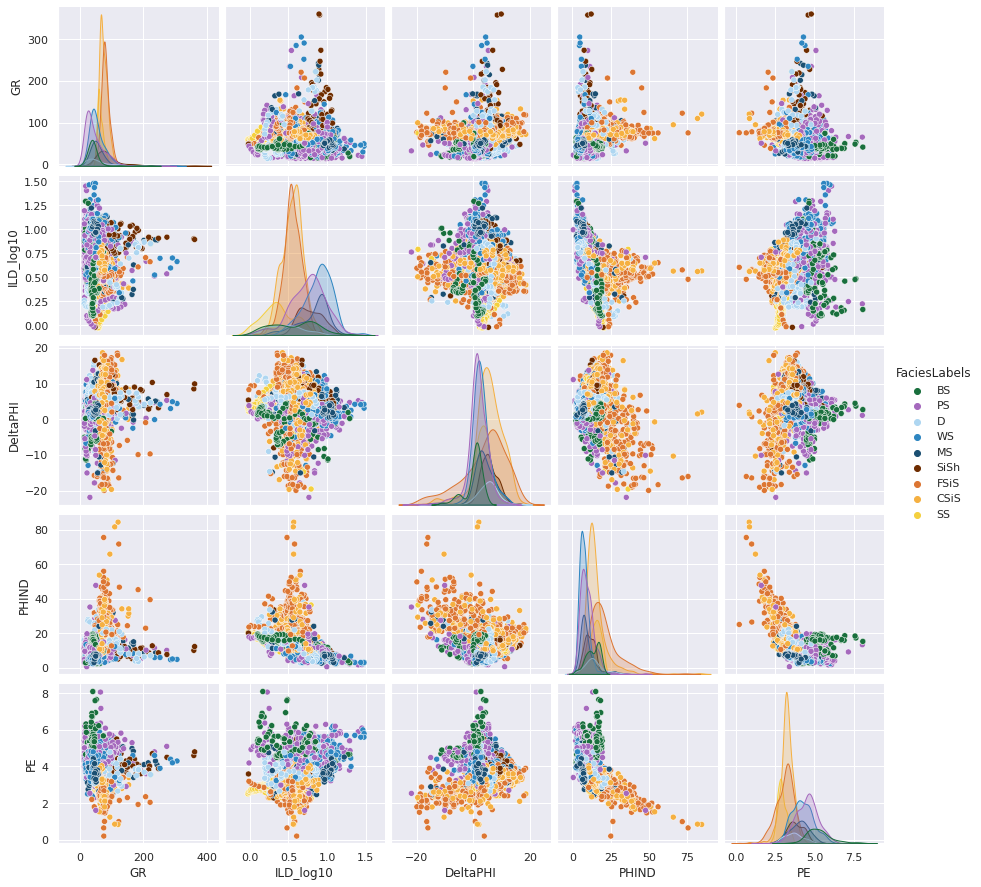

In [18]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(df.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)